# Importações

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
from sqlalchemy import create_engine

# Conexão ao PostgreSQl

In [ ]:
user = "avnadmin"
password = "AVNS_9fZb3BkX9qGXxKpxsrZ"
host = "postgresql-iscac.f.aivencloud.com"
port = "25674"
bucket = "Seasonality"

# URL de conexão com PostgreSQL
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{bucket}')

#Nome da tabela 
bicycle_counter ='bicycle_counter'

# Importar dados do PostgreSQL

In [2]:
# Como a Api ainda não esta a funcionar, vou importar os dados de um csv
df = pd.read_csv('../all_bike_counts.csv', parse_dates=['detected'], dtype='int32')
df = df.set_index('detected')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22632 entries, 2021-08-01 00:00:00 to 2024-02-29 23:00:00
Data columns (total 62 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   direction_2   22632 non-null  int32
 1   count_2       22632 non-null  int32
 2   direction_3   22632 non-null  int32
 3   count_3       22632 non-null  int32
 4   direction_4   22632 non-null  int32
 5   count_4       22632 non-null  int32
 6   direction_5   22632 non-null  int32
 7   count_5       22632 non-null  int32
 8   direction_6   22632 non-null  int32
 9   count_6       22632 non-null  int32
 10  direction_7   22632 non-null  int32
 11  count_7       22632 non-null  int32
 12  direction_8   22632 non-null  int32
 13  count_8       22632 non-null  int32
 14  direction_9   22632 non-null  int32
 15  count_9       22632 non-null  int32
 16  direction_10  22632 non-null  int32
 17  count_10      22632 non-null  int32
 18  direction_11  22632 non-null  i

In [3]:
df_loc = pd.read_csv('../all_counter_locations.csv')
df_loc.info()
print()
print(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   locationId         31 non-null     int64  
 1   tenantIdentifier   31 non-null     object 
 2   name               31 non-null     object 
 3   cp7                31 non-null     object 
 4   freguesia          31 non-null     object 
 5   directionPositive  0 non-null      float64
 6   directionNegative  0 non-null      float64
 7   latitude           31 non-null     float64
 8   longitude          31 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 2.3+ KB

                     direction_2  count_2  direction_3  count_3  direction_4  \
detected                                                                       
2021-08-01 00:00:00            0        0            1        1            0   
2021-08-01 01:00:00            3        3            0        2    

# Análises

### 1.Visualizar todas as localizações

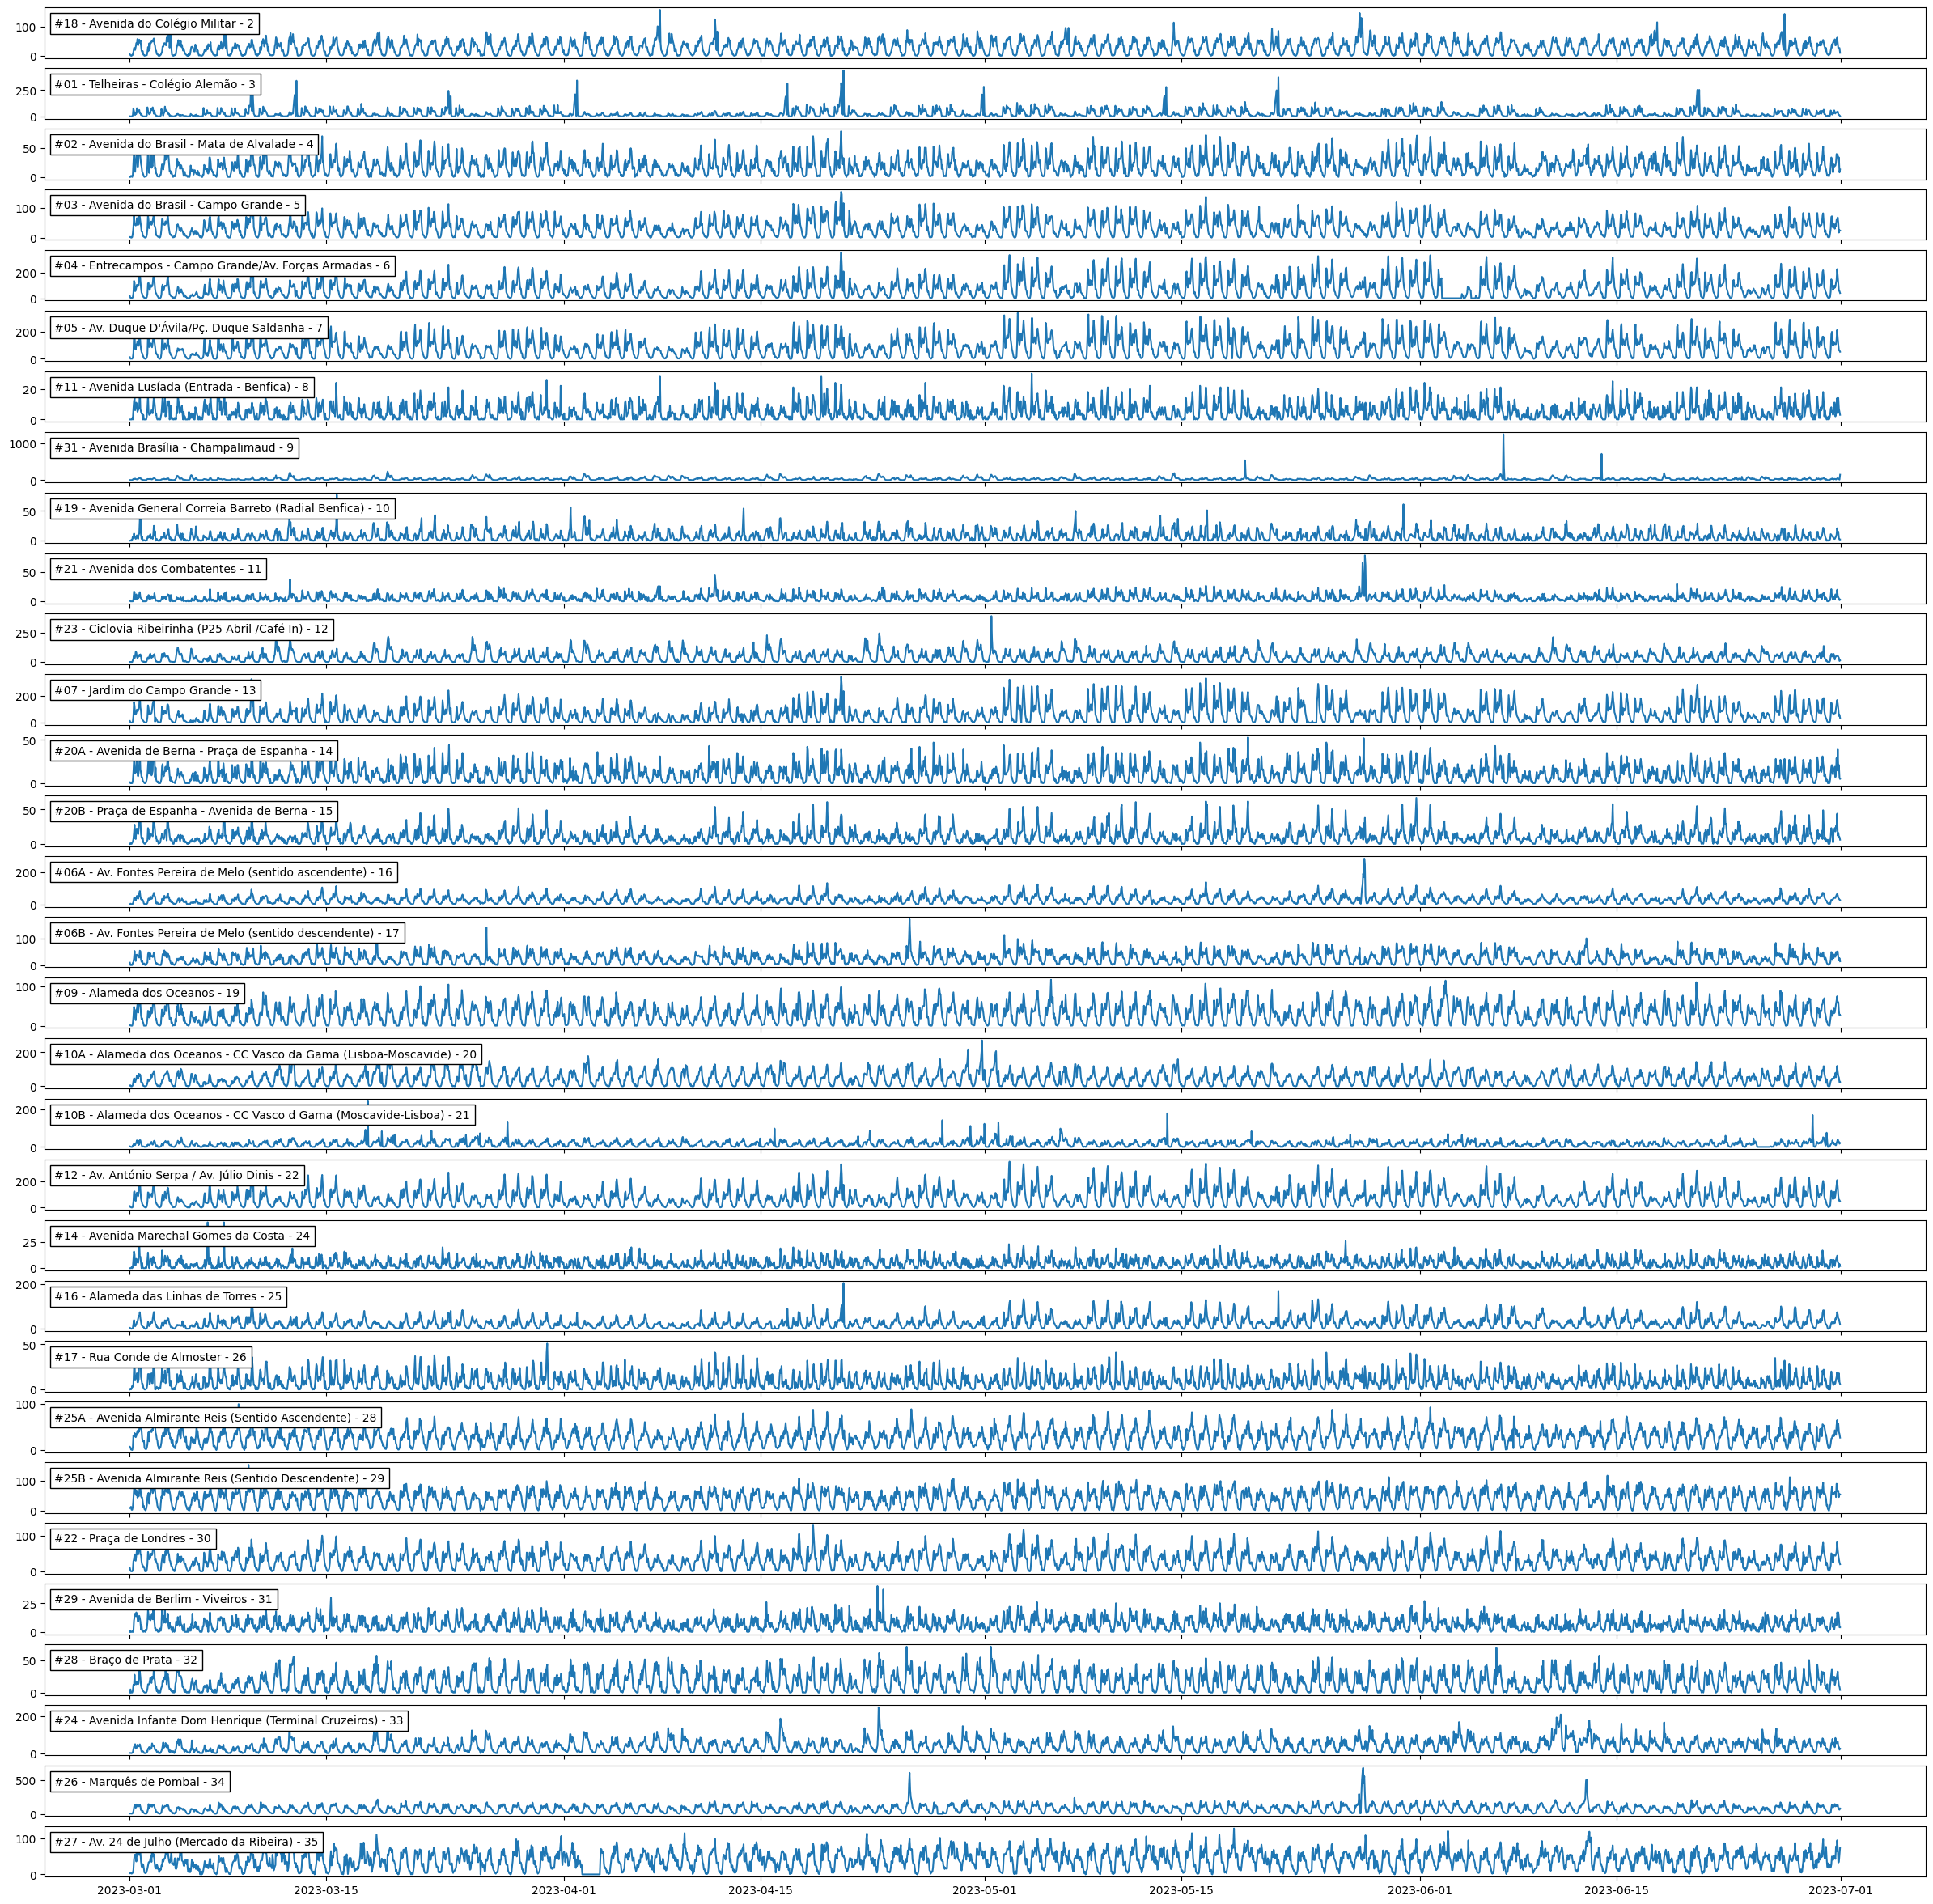

In [4]:
locationId_all = df_loc.locationId.to_list()  # converte a coluna location numa lista
locationId_remove = [] # lista de ID´s que se pretende remover, mas neste caso esta vazia
locationId_keep = [elem for elem in locationId_all if elem not in locationId_remove] #Filtra esses IDs com base em locationId_remove para obter os IDs a serem mantidos

fig, ax = plt.subplots(len(locationId_keep), 1, figsize=(30,30), sharex=True) # grafico que vai criar varios subplots, sendo que o tamanho do  gráfico é igual ao número de id´s
for i,location in enumerate(locationId_keep):
    ax[i].plot(df.query('"2023-03"<index<"2023-07"').loc[:,f'count_{location}']) #intervalo das datas que se pretende ver o gráfico
    counter_name = AnchoredText(df_loc.query('locationId == @location').name.values[0] + ' - ' + str(location), loc="upper left")
    ax[i].add_artist(counter_name)
plt.show()

### Visualização sazonal

In [5]:
# Prepação dos dados para o gráfico
def prep_df_fig(df_all, start_date, end_date, column):
    df_raw = df_all.query('@start_date <= index < @end_date').filter([column])
    df_raw = df_raw.assign(
        woy = df_raw.index.isocalendar().week,
        dow = df_raw.index.dayofweek,
        hod = df_raw.index.hour
        ).reset_index()
    df_raw = df_raw.assign(idx = (df_raw.dow)*24 + df_raw.hod)
    df_fig = df_raw.pivot(index='idx', columns='woy', values=column)
    df_fig = df_fig.assign(mean_hour = df_fig.agg('mean', axis=1))
    return df_fig

# Gera uma lista de posições para o eixo X (ticks) com base em dias e horas. 
def prep_ticks_fig(hour_list):
    hour_list_aux = [0] + hour_list
    tick_list = []
    tick_label_list = []
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i,d in zip(np.arange(0, 167, 24),days):
        tick_list_aux = hour_list_aux + i
        tick_list = tick_list + tick_list_aux.tolist()
        tick_label_list_aux = [d] + [str(h)+':00' for h in hour_list]
        tick_label_list = tick_label_list + tick_label_list_aux
    return tick_list, tick_label_list

# Faz o gráfico de linhas
def plot_weekly_count(df_all, df_all_loc, start_date, end_date, loc, hour_list):
    location_name = df_all_loc.query('locationId == @loc').name.values[0]
    column = 'count_' + str(location)
    df_plot = prep_df_fig(df_all, start_date, end_date, column)
    tick_list, tick_label_list = prep_ticks_fig(hour_list)
    fig,ax = plt.subplots(1, 1, figsize=(26,4))
    for i in tick_list:
        if i in np.arange(0, 167, 24):
            ax.axvline(i, color='cadetblue', linestyle='dashed', linewidth=1.5)
        else:
            ax.axvline(i, color='aliceblue', linestyle='dashed')
    for i in list(range(len(df_plot.columns[:-1]))):
        ax.plot(df_plot.iloc[:,i], color='gray', alpha=0.15, linewidth=1.5)
    ax.plot(df_plot.iloc[:,-1], color='indianred', alpha=0.8, linewidth=1.5, label='mean')
    plt.xticks(ticks=tick_list, labels=tick_label_list)
    ax.set_title(f'Weekly count at {location_name}   ({start_date} - {end_date})')
    ax.legend()
    plt.show()

# Faz o gráfico de barras
def plot_weekly_bar_count(df_all, df_all_loc, start_date, end_date, loc, hour_list):
    # Filtrar o nome da localização
    location_name = df_all_loc.query('locationId == @loc').name.values[0]
    
    # Selecionar a coluna de contagem baseada no ID da localização
    column = f'count_{location}'
    
    # Preparar os dados com a função já existente
    df_plot = prep_df_fig(df_all, start_date, end_date, column)
    tick_list, tick_label_list = prep_ticks_fig(hour_list)
    
    # Calcular a média de contagem por hora/dia
    mean_per_hour = df_plot.iloc[:, :-1].mean(axis=1)
    
    # Criar o gráfico de barras
    fig, ax = plt.subplots(figsize=(26, 4))
    ax.bar(df_plot.index, mean_per_hour, color='skyblue', alpha=0.8, label='Mean Count')

    # Adicionar divisões nos dias da semana
    for i in np.arange(0, 167, 24):
        ax.axvline(i, color='cadetblue', linestyle='dashed', linewidth=1.5)

    # Configurar o eixo X com os rótulos de horas e dias
    plt.xticks(ticks=tick_list, labels=tick_label_list, rotation=45, ha='right')
    ax.set_title(f'Weekly Count (Bar Plot) at {location_name} ({start_date} - {end_date})')
    ax.set_ylabel('Mean Count')
    ax.legend()
    plt.tight_layout()
    plt.show()

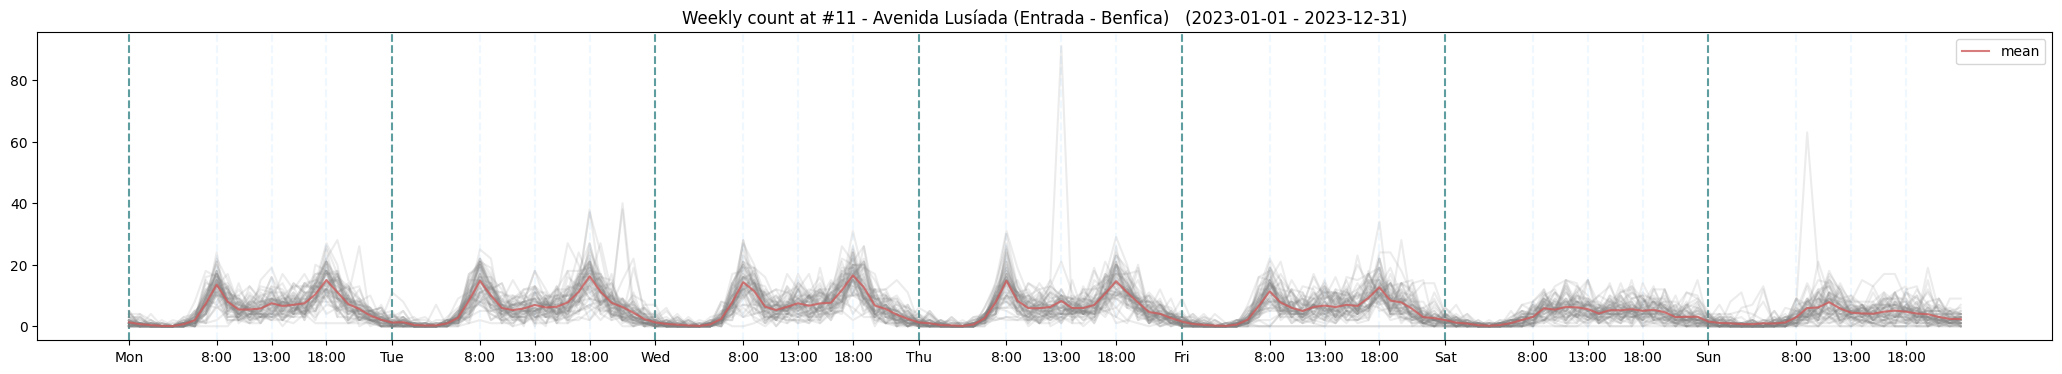

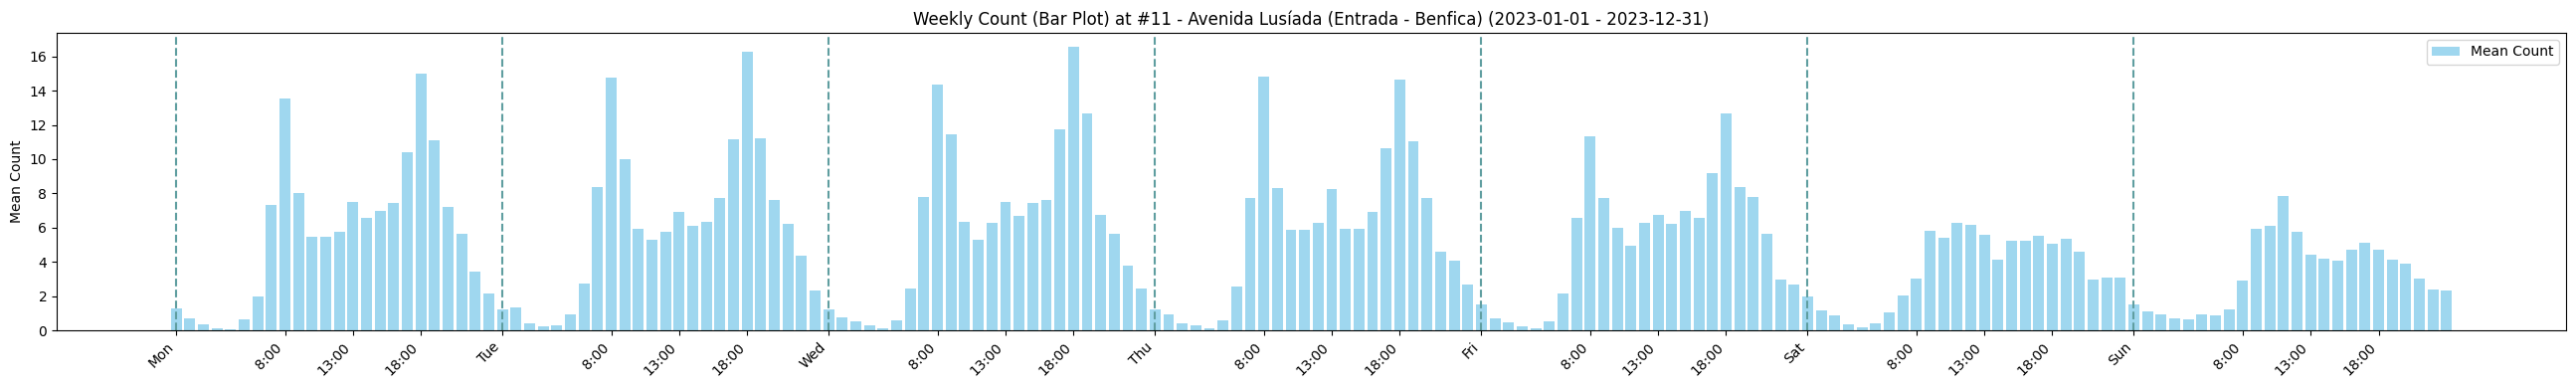

In [6]:
location = 8
s_date = "2023-01-01"
e_date = "2023-12-31"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

In [32]:
def calculate_weekly_mean(df, start_date, end_date, location_id):
    df_filtered = df[(df.index >= start_date) & (df.index < end_date)]
    df_filtered_location = df_filtered[f'count_{location_id}']
    weekly_mean = df_filtered_location.resample('W').mean()  # Resample por semana
    return weekly_mean


In [42]:
def plot_seasons(df, df_loc, location_id, seasons):
    # Verificar se a localização existe em df_loc
    location_name = df_loc[df_loc['locationId'] == location_id]['name'].values
    
    # Verifica se o location_id foi encontrado no df_loc
    if len(location_name) == 0:
        raise ValueError(f"Localização com ID {location_id} não encontrada.")
    
    location_name = location_name[0]  # Caso haja mais de um valor, pegamos o primeiro

    # Criação do gráfico
    fig, ax = plt.subplots(figsize=(14, 6))

    # Para cada estação, filtra os dados e plota a média semanal
    for season_name, (start_date_str, end_date_str) in seasons.items():
        start_date = pd.to_datetime(start_date_str)
        end_date = pd.to_datetime(end_date_str)
        
        # Calcula as médias semanais para a estação
        seasonal_mean = calculate_weekly_mean(df, start_date, end_date, location_id)
        
        # Plota a média semanal no gráfico
        ax.plot(seasonal_mean.index, seasonal_mean.values, label=f'{season_name} - {location_name}')

    # Ajuste de ticks para o eixo X (semanais)
    ax.set_xticks(seasonal_mean.index[::4])  # Exibe a cada 4 semanas
    ax.set_xticklabels([d.strftime('%d-%b') for d in seasonal_mean.index[::4]], rotation=45)

    # Títulos e legendas
    ax.set_title(f'Contagens de Bicicletas por Estação - Local: {location_name}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Contagem Média Semanal')
    ax.legend(title="Estações")

    # Melhorar a legibilidade ajustando o formato dos ticks
    fig.autofmt_xdate(rotation=45)

    # Ajuste do layout para garantir que tudo se ajuste corretamente
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()





In [ ]:
location = 8
seasons = {
    'Primavera': ['2023-03-21', '2023-06-21'],
    'Verão': ['2023-06-21', '2023-09-23'],
    'Outono': ['2023-09-23', '2023-12-21'],
    'Inverno': ['2023-12-21', '2024-03-21'],
}

plot_seasons(df, df_loc, location, seasons)


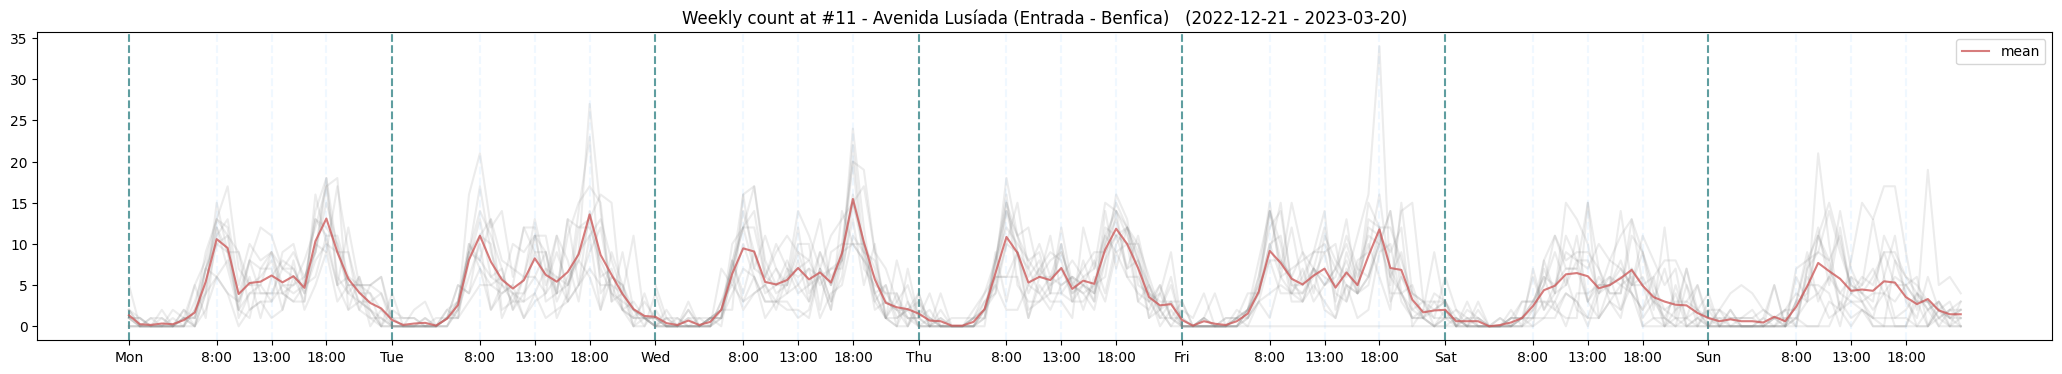

In [9]:
# inverno
location = 8
s_date = "2022-12-21"
e_date = "2023-03-20"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)

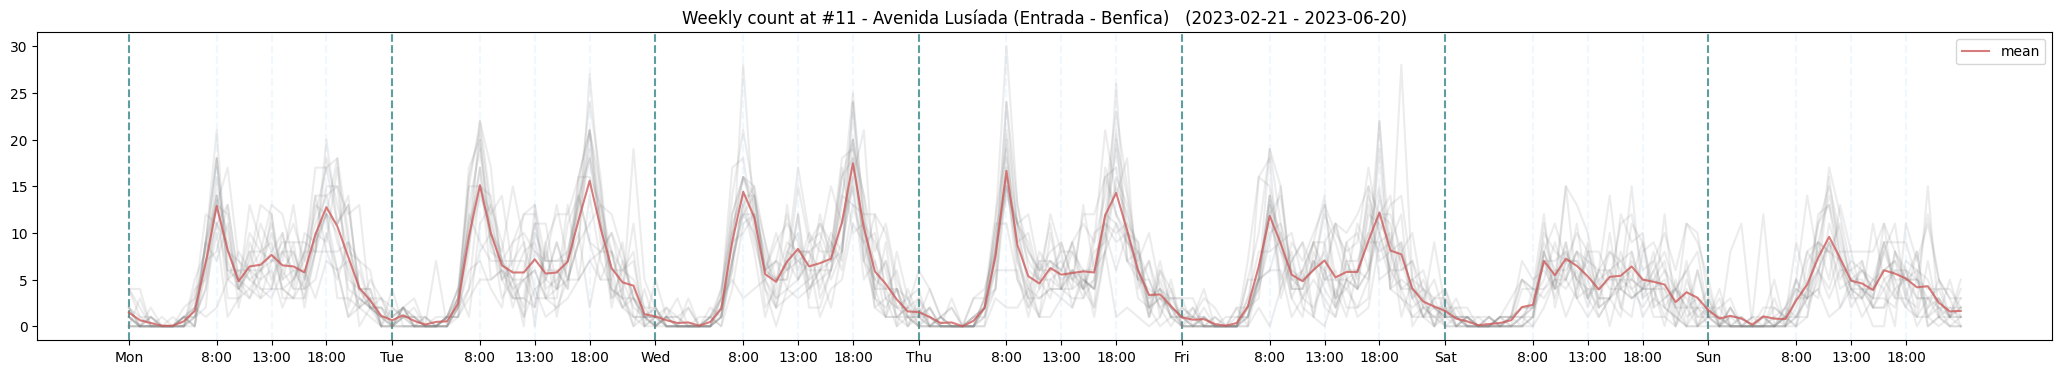

In [11]:
# primavera
location = 8
s_date = "2023-02-21"
e_date = "2023-06-20"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)

In [ ]:
location = 13
s_date ="2023-02-27"
e_date = "2023-07-03"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

In [ ]:
location = 12
s_date ="2023-02-27"
e_date = "2023-07-03"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

In [ ]:
location = 21
s_date ="2023-02-27"
e_date = "2023-07-03"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)

In [ ]:
location = 9
s_date ="2023-02-27"
e_date = "2023-07-03"
ticks_hours = [8, 13, 18]

plot_weekly_count(df, df_loc, s_date, e_date, location, ticks_hours)
plot_weekly_bar_count(df, df_loc, s_date, e_date, location, ticks_hours)